# Trajectory Optimization Example 2

Construct a trajectory with two states (pose + velocity). Lock the first state (pose + velocity), and optimize the second state (pose + velocity) with addtional velocity measurements at interpolated times.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(6, suppress=True)

from pylgmath import Transformation
from pysteam.trajectory import Time
from pysteam.trajectory.const_vel import Interface as TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver, DoglegGaussNewtonSolver
from pysteam.evaluable import vspace as vspaceev, se3 as se3ev
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar

Set up the trajectory that uses a constant velocity motion prior:


In [2]:
# states with initial conditions and associated timestamps
NUM_STATES = 2
DT = 1
states = [(DT * i, Transformation(), i * np.ones((6, 1))) for i in range(NUM_STATES)]

# wrap states with corresponding steam state variables (no copy!)
state_vars = [(t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states]
state_vars[0][1].locked = True  # lock first pose
state_vars[0][2].locked = True  # lock first velocity

# construct a trajectory
Qc_inv = np.diag(1 / np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))  # smoothing factor diagonal
traj = TrajectoryInterface(Qc_inv=Qc_inv)
for t, T_vi, w_iv_inv in state_vars:
  traj.add_knot(time=Time(t), T_k0=T_vi, w_0k_ink=w_iv_inv)

# fake velocity measurements at interpolated times
w_iv_inv_meas = []
w_iv_inv_meas.append((0.1 * DT, np.array([[0.1, -0.1, 0.1, -0.1, 0.1, 0.3]]).T))
w_iv_inv_meas.append((0.3 * DT, np.array([[0.3, -0.3, -0.3, 0.3, 0.6, 0.3]]).T))

# velocity measurements -> cost terms
noise_model = StaticNoiseModel(np.eye(6) * 0.001)
loss_func = L2LossFunc()
cost_terms = []
for t, w in w_iv_inv_meas:
  intp_vel = traj.get_velocity_interpolator(Time(secs=t))
  error_func = vspaceev.add(VSpaceStateVar(w, locked=True), vspaceev.neg(intp_vel))
  cost_term = WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
  cost_terms.append(cost_term)


Construct the optimization problem and solve:


In [3]:
opt_prob = OptimizationProblem()
opt_prob.add_state_var(*[v for state_var in state_vars for v in state_var[1:]])
opt_prob.add_cost_term(*traj.get_prior_cost_terms())
opt_prob.add_cost_term(*cost_terms)

solver = DoglegGaussNewtonSolver(opt_prob, verbose=True)
solver.optimize()

Begin Optimization
------------------
Number of States:  2
Number of Cost Terms:  3
Initial Cost:  1265.3999999999999
Iteration:    1  -  Cost:   429.6417  -  TR Shrink:  0.000  -  AvP Ratio:  0.686  -  Dogleg Segment: Gauss Newton   
Iteration:    2  -  Cost:    64.7027  -  TR Shrink:  0.000  -  AvP Ratio:  0.950  -  Dogleg Segment: Gauss Newton   
Iteration:    3  -  Cost:    57.0088  -  TR Shrink:  0.000  -  AvP Ratio:  0.449  -  Dogleg Segment: Gauss Newton   
Iteration:    4  -  Cost:    51.5889  -  TR Shrink:  0.000  -  AvP Ratio:  0.574  -  Dogleg Segment: Gauss Newton   
Iteration:    5  -  Cost:    48.3310  -  TR Shrink:  0.000  -  AvP Ratio:  0.868  -  Dogleg Segment: Gauss Newton   
Iteration:    6  -  Cost:    47.9622  -  TR Shrink:  0.000  -  AvP Ratio:  0.404  -  Dogleg Segment: Gauss Newton   
Iteration:    7  -  Cost:    47.6665  -  TR Shrink:  0.000  -  AvP Ratio:  1.223  -  Dogleg Segment: Gauss Newton   
Iteration:    8  -  Cost:    47.6060  -  TR Shrink:  0.000  -  

Print out results:


In [4]:
print("First Pose:                 \n", states[0][1])
print("Second Pose:                \n", states[1][1])
print("First Vel:                  \n", states[0][2].squeeze())
print("Second Vel:                 \n", states[1][2].squeeze())
print("Interp. Vel (t=t0+0.5*DT):  \n",
      traj.get_velocity_interpolator(Time(states[0][0]) + Time(secs=0.5 * DT)).evaluate().squeeze())


First Pose:                 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Second Pose:                
 [[ 0.668524  0.469986  0.576358 -0.135386]
 [ 0.138614  0.682671 -0.717458  0.070238]
 [-0.730658  0.559529  0.391236 -1.088678]
 [ 0.        0.        0.        1.      ]]
First Vel:                  
 [0. 0. 0. 0. 0. 0.]
Second Vel:                 
 [ 0.51835  -0.114255 -2.793241  1.773141  2.100939 -1.877413]
Interp. Vel (t=t0+0.5*DT):  
 [ 0.395957 -0.412294 -0.746493  0.593696  0.905795  0.120605]


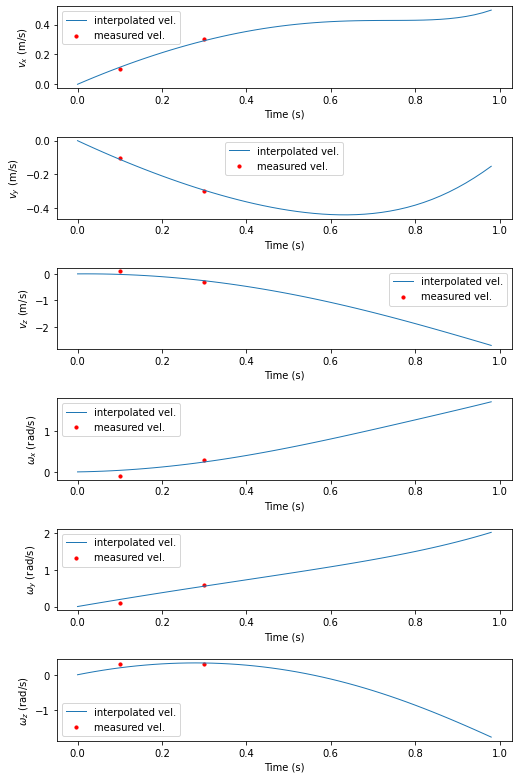

In [5]:
# measurement values
meas_times = [x[0] for x in w_iv_inv_meas]
meas_vels = np.array([x[1].flatten() for x in w_iv_inv_meas])

# plot values
plot_times = lambda: np.arange(0.0, 1.0, 0.02)
plot_intp_vels = np.array(
    [traj.get_velocity_interpolator(Time(secs=t * DT)).evaluate().squeeze() for t in plot_times()])

fig = plt.figure()

plot_number = 611
fig.set_size_inches(8, 12)
fig.subplots_adjust(left=0.16, right=0.95, bottom=0.1, top=0.95, wspace=0.7, hspace=0.6)

ylabels = [
    '$v_x$ (m/s)', '$v_y$ (m/s)', '$v_z$ (m/s)', '$\omega_x$ (rad/s)', '$\omega_y$ (rad/s)', '$\omega_z$ (rad/s)'
]
for i in range(6):
  ax = fig.add_subplot(plot_number + i)
  ax.plot(plot_times(), plot_intp_vels[:, i].squeeze(), '-', linewidth=1.0, label='interpolated vel.')
  if len(meas_times):
    ax.scatter(meas_times, meas_vels[:, i].squeeze(), s=10, c='r', label='measured vel.')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel(ylabels[i])
  ax.legend()